In [12]:
import os
import pandas as pd

input_folder = r"C:\Users\Kaan\Desktop\thesis\csv_files"  # Replace with the folder path containing your CSV files
output_file = r"C:\Users\Kaan\Desktop\thesis\CV_scores.csv"  # Replace with the desired output file path

    # Initialize a list to store the results
results = []

    # Iterate over all files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Process only CSV files
        file_path = os.path.join(input_folder, filename)
        
        try:
            # Split the file name into components
            parts = filename.split('_')
            model_name = parts[0]
            cat = parts[1]
            range_val = parts[2]
            task = '_'.join(parts[3:]).replace(".csv", "")
            
            # Read the CSV file, setting the first column as the index
            data = pd.read_csv(file_path, index_col=0)

            # Calculate CV for each column
            column_cvs = (data.std() / data.mean()).tolist()
            
            # Take the first 10 column CVs, pad with None if fewer than 10 columns
            column_cvs = column_cvs[:10] + [None] * (10 - len(column_cvs))

            overall_cv = sum(column_cvs) / len(list(column_cvs))

            row = [model_name, cat, range_val, task] + column_cvs + [overall_cv]
            
            # Append the row to the results
            results.append(row)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Create a DataFrame for the results
column_names = ["Model", "Category", "Range", "Task"] + [f"Column_{i+1}_CV" for i in range(10)] + ["Overall_CV"]
output_df = pd.DataFrame(results, columns=column_names)
# Save the results to the output CSV file
output_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")




Results saved to C:\Users\Kaan\Desktop\thesis\CV_scores.csv


In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Category_NAMES = {
    0: "Letter A",
    1: "Random Letters",
    2: "Word CAT",
    3: "Random Words"
}

TASK_REPLACEMENTS = {
    "gen_data": "Numerosity Generation",
    "naming_data": "Numerosity Naming"
}

def calculate_and_plot_cv_combined(input_folder, output_folder):
    """
    Calculates and plots CV graphs for range 10 and range 100 in separate figures.
    Each figure has tasks as rows and categories as columns, with y-axis scaled to 2 for all plots.
    Task names are updated, and x-axis labels are adjusted for range 100.
    
    Parameters:
    - input_folder: Path to the folder containing CSV files.
    - output_folder: Path to save the plots.
    """
    sns.set(style="whitegrid")  # Use a clean seaborn style
    cv_data = []

    # Process each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            
            try:
                # Extract model, category, range, and task from the file name
                parts = filename.split('_')
                model_name = parts[0]
                category = int(parts[1].replace("cat", ""))
                range_val = parts[2].replace("r", "")
                task = '_'.join(parts[3:]).replace(".csv", "")
                
                # Replace task names
                task = TASK_REPLACEMENTS.get(task, task)
                
                # Read the CSV file with the first column as the index
                data = pd.read_csv(file_path, index_col=0)
                
                # Calculate CV for each column
                column_cvs = (data.std() / data.mean()).tolist()
                
                # Prepare data for plotting
                for i, cv in enumerate(column_cvs, start=1):
                    cv_data.append({
                        "Model": model_name,
                        "Category": category,
                        "Range": range_val,
                        "Task": task,
                        "Numerosity": i,
                        "CV": cv
                    })
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    # Convert the data to a DataFrame for easier plotting
    cv_df = pd.DataFrame(cv_data)

    # Plotting for Range 10 and Range 100
    for range_val in ["10", "100"]:
        range_df = cv_df[cv_df["Range"] == range_val]
        tasks = sorted(range_df["Task"].unique())
        categories = sorted(range_df["Category"].unique())

        # Create subplots
        num_rows = len(tasks)
        num_cols = len(categories)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharex=True)

        for i, task in enumerate(tasks):
            for j, category in enumerate(categories):
                ax = axes[i, j]
                task_category_df = range_df[(range_df["Task"] == task) & (range_df["Category"] == category)]
                
                if not task_category_df.empty:
                    sns.lineplot(
                        data=task_category_df,
                        x="Numerosity",
                        y="CV",
                        hue="Model",
                        marker="o",
                        errorbar=('ci', 95),  # Adds shaded CI regions
                        ax=ax,
                        legend=(j == 0)  # Suppress legend on individual plots
                    )
                
                if i == 0:  # Add column titles
                    ax.set_title(Category_NAMES[category], fontsize=12)
                if j == 0:  # Add row labels
                    ax.set_ylabel(task, fontsize=12)

                # Set y-axis scaling to be consistent across all plots
                ax.set_ylim(-0.05, 1)
                ax.set_yticks([x / 10.0 for x in range(0, 11, 1)])  # Set ticks at 0.2 steps

                # Adjust x-axis labels for numerosity
                if range_val == "100":
                    ax.set_xticks(range(1, 11))  # Set ticks for numerosity positions
                    ax.set_xticklabels([x * 10 for x in range(1, 11)])  # Multiples of 10 for range 100
                else:
                    ax.set_xticks(range(1, 11))  # Range 10 remains as is
                    ax.set_xticklabels(range(1, 11))

                ax.tick_params(axis="both", labelsize=14)
                ax.grid(True)

        # Add the legend inside only the first subplot
        if "Model" in range_df.columns:
            handles, labels = axes[0, 0].get_legend_handles_labels()
            axes[0, 0].legend(
                handles, labels, loc="upper left", fontsize=10, frameon=False, title="Model"
            )

        # Overall figure adjustments
        plt.suptitle(f"CV Plots for Range {range_val}", fontsize=16, fontweight="bold")
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for better spacing
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

        # Save the figure;
        plot_filename = f"cv_specialized_plots_range_{range_val}.png"
        plt.savefig(os.path.join(output_folder, plot_filename))
        plt.close()
        print(f"Saved plot: {plot_filename}")


input_folder = r"C:\Users\Kaan\Desktop\thesis\csv_files"  # Replace with your folder containing CSV files
output_folder = r"C:\Users\Kaan\Desktop\thesis\plots"  # Replace with the folder to save plots
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

calculate_and_plot_cv_combined(input_folder, output_folder)


Saved plot: cv_plots_range_10.png
Saved plot: cv_plots_range_100.png


In [44]:
import os
import pandas as pd

# Define the MWE calculation function
def calculate_mwe(data):
    mwe_results = []

    for idx, column in enumerate(data.columns[1:]):  # Exclude the first column from calculation
        G = data[column].values  # Generated numerosity
        T = float(column)  # Target numerosity from the header

        # Calculate MWE for the current column
        mwe = (1 / len(G)) * sum(abs(G - T) / T)
        mwe_results.append(mwe)

    return mwe_results

# Directory containing CSV files
input_directory = r"C:\Users\Kaan\Desktop\thesis\csv_files"
output_file = r"C:\Users\Kaan\Desktop\thesis\mwe_results.csv"

# Store MWE results for all files
all_mwe_results = []

# Iterate through all CSV files in the folder
for file_name in os.listdir(input_directory):
    if file_name.endswith('.csv'):
        file_path = os.path.join(input_directory, file_name)

        # Extract model name, cat, r, and task from the file name
        model_name, cat, r, task, _ = file_name.replace('.csv', '').split('_')

        # Load the CSV file
        data = pd.read_csv(file_path)

        # Calculate MWE for the file
        mwe_results = calculate_mwe(data)

        # Pad or truncate the results to ensure exactly 10 values
        mwe_results = mwe_results[:10] + [None] * (10 - len(mwe_results))

        # Prepare a result row
        result_row = {
            "Model": model_name,
            "Cat": cat,
            "Range": r,
            "Task": task,
        }
        for i in range(10):
            result_row[str(i + 1)] = mwe_results[i]

        all_mwe_results.append(result_row)

# Write results to a CSV file
columns = ["Model", "Cat", "Range", "Task"] + [str(i) for i in range(1, 11)]
results_df = pd.DataFrame(all_mwe_results, columns=columns)
results_df.to_csv(output_file, index=False)

print(f"MWE results saved to {output_file}")


MWE results saved to C:\Users\Kaan\Desktop\thesis\mwe_results.csv


In [45]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

CATEGORY_NAMES = {
    0: "Letter A",
    1: "Random Letters",
    2: "Word CAT",
    3: "Random Words"
}

TASK_REPLACEMENTS = {
    "gen": "Numerosity Generation",
    "naming": "Numerosity Naming"
}

def visualize_mwe(input_file, output_folder):
    """
    Visualizes MWE values based on models, categories, ranges, and tasks.

    Parameters:
    - input_file: Path to the MWE results CSV file.
    - output_folder: Path to save the plots.
    """
    sns.set(style="whitegrid")  # Use a clean seaborn style

    # Load the MWE results
    mwe_data = pd.read_csv(input_file)

    # Extract numeric values from the 'Cat' column
    mwe_data['Cat'] = mwe_data['Cat'].str.extract(r'(\d+)').astype(int)

    # Process the data
    for range_val in mwe_data['Range'].unique():
        range_df = mwe_data[mwe_data['Range'] == range_val]
        tasks = sorted(range_df['Task'].unique())
        categories = sorted(range_df['Cat'].unique())

        # Determine numerosity range based on the Range value
        if range_val == "r10":
            numerosity_range = list(range(1, 11))
            x_tick_labels = numerosity_range
        elif range_val == "r100":
            numerosity_range = list(range(1, 11))
            x_tick_labels = [x * 10 for x in numerosity_range]
        else:
            raise ValueError(f"Unknown range value: {range_val}")

        # Create subplots
        num_rows = len(tasks)
        num_cols = len(categories)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharex=True)

        for i, task in enumerate(tasks):
            for j, category in enumerate(categories):
                ax = axes[i, j] if num_rows > 1 and num_cols > 1 else axes[max(i, j)]
                task_category_df = range_df[(range_df['Task'] == task) & (range_df['Cat'] == category)]

                if not task_category_df.empty:
                    melted_df = task_category_df.melt(
                        id_vars=['Model'], 
                        value_vars=[str(x) for x in numerosity_range], 
                        var_name='Numerosity', 
                        value_name='MWE'
                    )

                    # Ensure Numerosity values are numeric and in the correct range
                    melted_df['Numerosity'] = melted_df['Numerosity'].astype(int)
                    melted_df = melted_df[melted_df['Numerosity'].isin(numerosity_range)]

                    sns.lineplot(
                        data=melted_df,
                        x="Numerosity",
                        y="MWE",
                        hue="Model",
                        marker="o",
                        ax=ax,
                        legend=(j == 0)  # Suppress legend on individual plots
                    )

                if i == 0:  # Add column titles
                    ax.set_title(CATEGORY_NAMES.get(category, f"Category {category}"), fontsize=12)
                if j == 0:  # Add row labels
                    ax.set_ylabel(TASK_REPLACEMENTS.get(task, task), fontsize=12)

                # Set x-axis and y-axis limits and labels
                ax.set_xlim(0, max(numerosity_range))  # Start x-axis from 0
                ax.set_xticks([0] + numerosity_range)  # Add 0 to x-axis ticks
                ax.set_xticklabels([0] + x_tick_labels)  # Add 0 to x-axis labels
                ax.set_ylim(-0.05, 1)  # Constrain y-axis to 0-1
                ax.set_yticks([x / 10.0 for x in range(0, 11, 1)])  # Set ticks at 0.1 steps
                ax.tick_params(axis="both", labelsize=14)
                ax.grid(True)

        # Add the legend inside only the first subplot
        if "Model" in range_df.columns:
            handles, labels = axes[0, 0].get_legend_handles_labels()
            axes[0, 0].legend(
                handles, labels, loc="upper left", fontsize=10, frameon=False, title="Model"
            )

        # Overall figure adjustments
        plt.suptitle(f"MWE Plots for Range {range_val}", fontsize=16, fontweight="bold")
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for better spacing
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

        # Save the figure
        plot_filename = f"mwe_plots_range_{range_val}.png"
        plt.savefig(os.path.join(output_folder, plot_filename))
        plt.close()
        print(f"Saved plot: {plot_filename}")

# Example usage
input_file = r"C:\Users\Kaan\Desktop\thesis\mwe_results.csv"  # Path to your MWE results file
output_folder = r"C:\Users\Kaan\Desktop\thesis\plots"  # Replace with the folder to save plots
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

visualize_mwe(input_file, output_folder)


Saved plot: mwe_plots_range_r100.png
Saved plot: mwe_plots_range_r10.png


In [15]:
import os
import pandas as pd
import numpy as np

# Input and output paths
input_folder = r"C:\Users\Kaan\Desktop\thesis\csv_files"  # Replace with your folder path
output_file = r"C:\Users\Kaan\Desktop\thesis\CV_target_scores.csv"  # Replace with your output file path

# Initialize a list to store the results
results = []

# Iterate over all files in the folder
for filename in os.listdir(input_folder):
    if filename.endswith(".csv"):  # Process only CSV files
        file_path = os.path.join(input_folder, filename)
        
        try:
            # Split the file name into components
            parts = filename.split('_')
            model_name = parts[0]
            cat = parts[1]
            range_val = parts[2]
            task = '_'.join(parts[3:]).replace(".csv", "")
            
            # Read the CSV file, setting the first column as the index
            data = pd.read_csv(file_path, index_col=0)

            # Initialize lists to store std and CV values for columns
            column_stds = []
            column_cvs = []

            # Calculate std and CV based on deviation from target number (header)
            for col in data.columns:
                target_number = float(col)  # Use the column header as the target number
                values = data[col].dropna()  # Drop NaN values
                n = len(values)  # Number of data points

                if n > 1 and target_number != 0:
                    # Compute the sum of squared deviations from the target
                    squared_deviations = np.sum((values - target_number) ** 2)
                    # Compute the standard deviation
                    std = (squared_deviations / (n - 1)) ** 0.5
                    # Compute the coefficient of variation (CV)
                    cv = std / target_number
                else:
                    # Handle cases with insufficient data or zero target
                    std = None
                    cv = None

                column_stds.append(std)
                column_cvs.append(cv)

            # Take the first 10 column std and CVs, pad with None if fewer than 10 columns
            column_stds = column_stds[:10] + [None] * (10 - len(column_stds))
            column_cvs = column_cvs[:10] + [None] * (10 - len(column_cvs))

            # Calculate overall CV (average of valid CVs)
            valid_cvs = [cv for cv in column_cvs if cv is not None]
            overall_cv = sum(valid_cvs) / len(valid_cvs) if valid_cvs else None

            # Create a row for the results
            row = [model_name, cat, range_val, task] + column_stds + column_cvs + [overall_cv]
            
            # Append the row to the results
            results.append(row)
        except Exception as e:
            print(f"Error processing file {filename}: {e}")

# Create a DataFrame for the results
column_names = (
    ["Model", "Category", "Range", "Task"] +
    [f"Column_{i+1}_STD" for i in range(10)] +  # Column-wise standard deviations
    [f"Column_{i+1}_CV" for i in range(10)] +  # Column-wise CVs
    ["Overall_CV"]
)
output_df = pd.DataFrame(results, columns=column_names)

# Save the results to the output CSV file
output_df.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")


Results saved to C:\Users\Kaan\Desktop\thesis\CV_target_scores.csv


In [17]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Category names for labeling
Category_NAMES = {
    0: "Letter A",
    1: "Random Letters",
    2: "Word CAT",
    3: "Random Words"
}

# Task name replacements
TASK_REPLACEMENTS = {
    "gen_data": "Numerosity Generation",
    "naming_data": "Numerosity Naming"
}

def calculate_and_plot_cv_combined(input_folder, output_folder):
    """
    Calculates and plots CV graphs for range 10 and range 100 in separate figures.
    Each figure has tasks as rows and categories as columns, with y-axis scaled to 2 for all plots.
    Task names are updated, and x-axis labels are adjusted for range 100.
    
    Parameters:
    - input_folder: Path to the folder containing CSV files.
    - output_folder: Path to save the plots.
    """
    sns.set(style="whitegrid")  # Use a clean seaborn style
    cv_data = []  # Store calculated CV data

    # Process each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".csv"):
            file_path = os.path.join(input_folder, filename)
            
            try:
                # Extract model, category, range, and task from the file name
                parts = filename.split('_')
                model_name = parts[0]
                category = int(parts[1].replace("cat", ""))
                range_val = parts[2].replace("r", "")
                task = '_'.join(parts[3:]).replace(".csv", "")
                
                # Replace task names
                task = TASK_REPLACEMENTS.get(task, task)
                
                # Read the CSV file with the first column as the index
                data = pd.read_csv(file_path, index_col=0)
                
                # Calculate CV for each column in the data
                for col in data.columns:
                    target_number = float(col)  # Use the column header as the target number
                    values = data[col].dropna()  # Drop NaN values
                    n = len(values)  # Number of data points

                    if n > 1 and target_number != 0:
                        # Compute the sum of squared deviations from the target
                        squared_deviations = np.sum((values - target_number) ** 2)
                        # Compute the standard deviation
                        std = (squared_deviations / (n - 1)) ** 0.5
                        # Compute the coefficient of variation (CV)
                        cv = std / target_number
                    else:
                        # Handle cases with insufficient data or zero target
                        cv = None

                    # Append calculated CV to the data list
                    if cv is not None:
                        cv_data.append({
                            "Model": model_name,
                            "Category": category,
                            "Range": range_val,
                            "Task": task,
                            "Numerosity": int(col),  # Target number as numerosity
                            "CV": cv
                        })
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    # Convert the data to a DataFrame for easier plotting
    cv_df = pd.DataFrame(cv_data)

    # Plotting for Range 10 and Range 100
    for range_val in ["10", "100"]:
        range_df = cv_df[cv_df["Range"] == range_val]
        tasks = sorted(range_df["Task"].unique())
        categories = sorted(range_df["Category"].unique())

        # Create subplots
        num_rows = len(tasks)
        num_cols = len(categories)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows), sharex=True)

        for i, task in enumerate(tasks):
            for j, category in enumerate(categories):
                ax = axes[i, j] if num_rows > 1 else axes[j]
                task_category_df = range_df[(range_df["Task"] == task) & (range_df["Category"] == category)]
                
                if not task_category_df.empty:
                    sns.lineplot(
                        data=task_category_df,
                        x="Numerosity",
                        y="CV",
                        hue="Model",
                        marker="o",
                        ax=ax,
                        legend=(i == 0 and j == 0)  # Add legend only in the top-left plot
                    )
                
                if i == 0:  # Add column titles
                    ax.set_title(Category_NAMES[category], fontsize=12)
                if j == 0:  # Add row labels
                    ax.set_ylabel(task, fontsize=12)

                # Set y-axis scaling to be consistent across all plots
                ax.set_ylim(-0.05, 1.5)
                ax.set_yticks([x / 10.0 for x in range(0, 16, 2)])  # Set ticks at 0.2 steps

                # Adjust x-axis labels for numerosity
                if range_val == "100":
                    ax.set_xticks(range(1, 11))  # Set ticks for numerosity positions
                    ax.set_xticklabels([x * 10 for x in range(1, 11)])  # Multiples of 10 for range 100
                else:
                    ax.set_xticks(range(1, 11))  # Range 10 remains as is
                    ax.set_xticklabels(range(1, 11))

                ax.tick_params(axis="both", labelsize=14)
                ax.grid(True)

        # Add the legend inside only the first subplot
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles, labels, loc="upper center", fontsize=10, frameon=False, title="Model", ncol=len(categories)
        )

        # Overall figure adjustments
        plt.suptitle(f"CV Plots for Range {range_val}", fontsize=16, fontweight="bold")
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout for better spacing
        plt.subplots_adjust(hspace=0.4, wspace=0.4)

        # Save the figure
        plot_filename = f"cv_specialized_plots_range_{range_val}.png"
        plt.savefig(os.path.join(output_folder, plot_filename))
        plt.close()
        print(f"Saved plot: {plot_filename}")


# Input and output paths
input_folder = r"C:\Users\Kaan\Desktop\thesis\csv_files"  # Replace with your folder containing CSV files
output_folder = r"C:\Users\Kaan\Desktop\thesis\plots"  # Replace with the folder to save plots
os.makedirs(output_folder, exist_ok=True)  # Ensure the output folder exists

calculate_and_plot_cv_combined(input_folder, output_folder)


Saved plot: cv_specialized_plots_range_10.png
Saved plot: cv_specialized_plots_range_100.png


In [8]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = r'C:\Users\Kaan\Downloads/embedding_positions_mistral.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Initialize a list to store the row pairs and distances
distances = []
row_pairs = []

# Calculate Euclidean distances between sequential rows
for i in range(len(data) - 1):
    row1 = data.iloc[i].values
    row2 = data.iloc[i + 1].values
    distance = np.sqrt(np.sum((row1 - row2) ** 2))  # Euclidean distance formula
    distances.append(distance)
    row_pairs.append(f"{i + 1}-{i + 2}")  # Create row pair labels

# Create a DataFrame to store the results
distance_results = pd.DataFrame({
    "Row Pair": row_pairs,
    "Euclidean Distance": distances
})

# Display the resulting DataFrame
print(distance_results)


  Row Pair  Euclidean Distance
0      1-2            0.183277
1      2-3            0.084884
2      3-4            0.096618
3      4-5            0.103965
4      5-6            0.104986
5      6-7            0.111616
6      7-8            0.113650
7      8-9            0.116921
8     9-10            0.114620


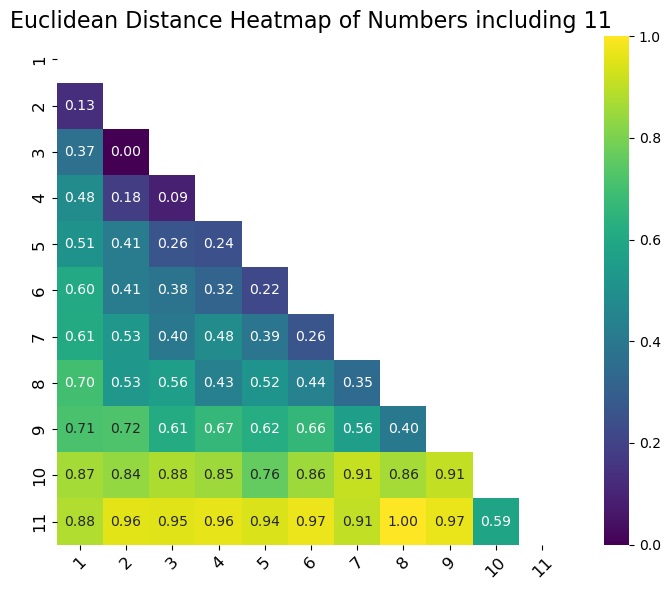

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
file_path = r'C:\Users\Kaan\Desktop\thesis\embedding_positions_7b.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Number of rows in the dataset
num_rows = len(data)

# Initialize a squared matrix to store distances
distance_matrix = np.zeros((num_rows, num_rows))
# Get global min and max across both models, excluding diagonal
global_min, global_max = float('inf'), float('-inf')

# Calculate Euclidean distances for every pair of rows
for i in range(num_rows):
    for j in range(num_rows):
        row1 = data.iloc[i].values
        row2 = data.iloc[j].values
        distance = np.sqrt(np.sum((row1 - row2) ** 2))  # Euclidean distance formula
        distance_matrix[i, j] = distance

non_diag_values = distance_matrix[~np.eye(num_rows, dtype=bool)]  # Mask diagonal
if non_diag_values.size > 0:  # Ensure there are non-diagonal values
    global_min = min(global_min, np.min(non_diag_values))
    global_max = max(global_max, np.max(non_diag_values))


mask = ~np.eye(num_rows, dtype=bool)  # Mask for non-diagonal elements

# Normalize only non-diagonal elements
distance_matrix[mask] = (distance_matrix[mask] - global_min) / (global_max - global_min)
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(distance_matrix, dtype=bool))  # Exclude the diagonal

# Plot the lower triangle heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    distance_matrix,
    mask=mask,
    cmap='viridis',
    annot=True,
    fmt=".2f",
    cbar=True,
    square=True,
    linewidths=0  # Remove gridlines
)

# Set ticks at the center of each cell
plt.xticks(ticks=np.arange(0.5, num_rows, 1), labels=[f"{i+1}" for i in range(num_rows)], rotation=45, fontsize=12)
plt.yticks(ticks=np.arange(0.5, num_rows, 1), labels=[f"{i+1}" for i in range(num_rows)], fontsize=12)

# Title and layout
plt.title('Euclidean Distance Heatmap of Numbers including 11', fontsize=16)
plt.tight_layout()
plt.show()


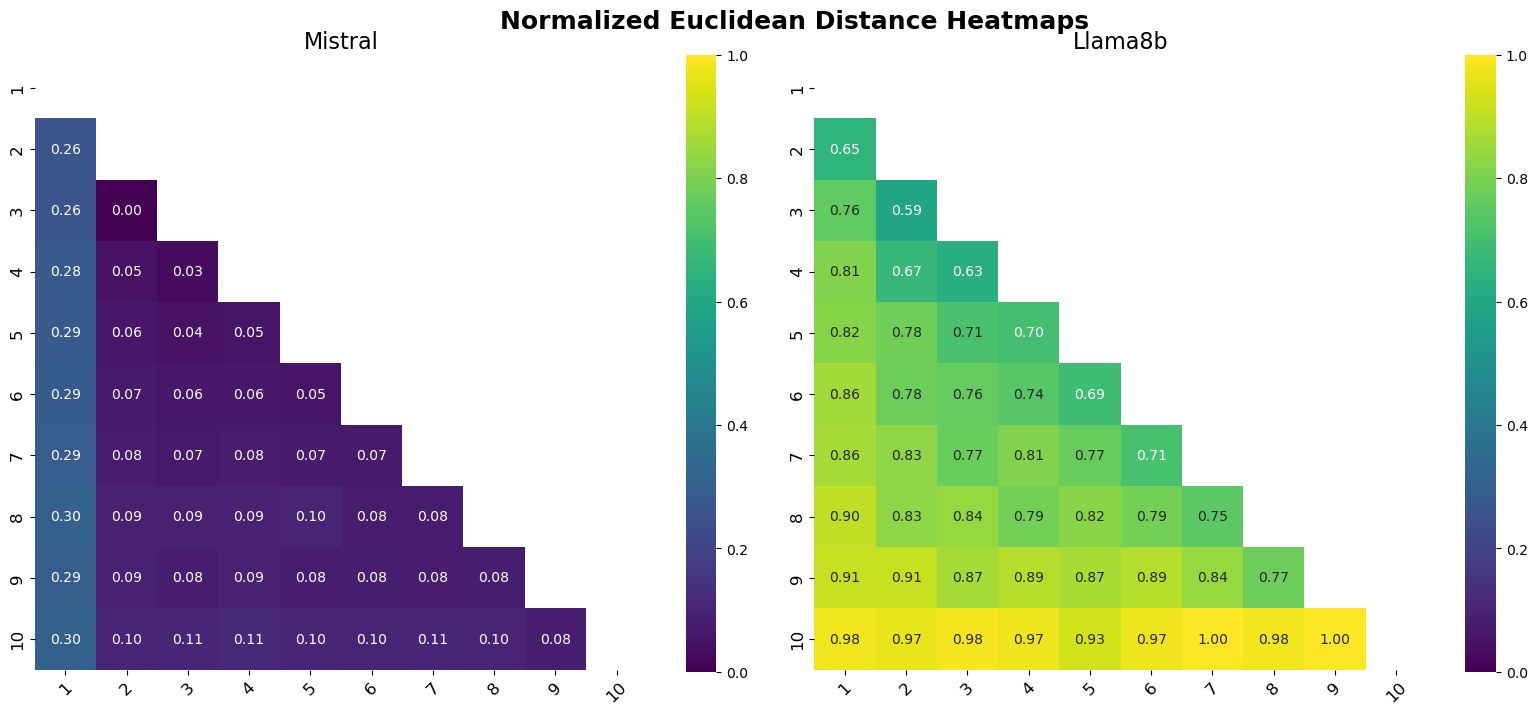

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load both datasets
models = ["mistral", "llama8b"]
file_paths = {model: rf'C:\Users\Kaan\Desktop\thesis\{model}_embedding_positions_Numbers.csv' for model in models}
data_dict = {model: pd.read_csv(file_paths[model]) for model in models}

# Compute distance matrices for both models
distance_matrices = {}
num_rows = len(data_dict["mistral"])  # Assuming both datasets have the same number of rows

for model, data in data_dict.items():
    distance_matrix = np.zeros((num_rows, num_rows))

    for i in range(num_rows):
        for j in range(i):  # Only calculate lower triangle
            row1 = data.iloc[i].values
            row2 = data.iloc[j].values
            distance = np.sqrt(np.sum((row1 - row2) ** 2))  # Euclidean distance
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Symmetric assignment

    distance_matrices[model] = distance_matrix

# Get global min and max across both models, excluding diagonal
global_min, global_max = float('inf'), float('-inf')

for model, distance_matrix in distance_matrices.items():
    non_diag_values = distance_matrix[~np.eye(num_rows, dtype=bool)]  # Mask diagonal
    if non_diag_values.size > 0:  # Ensure there are non-diagonal values
        global_min = min(global_min, np.min(non_diag_values))
        global_max = max(global_max, np.max(non_diag_values))

# Normalize all distance matrices (excluding diagonal)
for model in distance_matrices:
    distance_matrix = distance_matrices[model].copy()
    mask = ~np.eye(num_rows, dtype=bool)  # Mask for non-diagonal elements

    # Normalize only non-diagonal elements
    distance_matrix[mask] = (distance_matrix[mask] - global_min) / (global_max - global_min)

    # Keep diagonal as 0 (unchanged)
    distance_matrices[model] = distance_matrix

# Create a mask for the upper triangle
mask = np.triu(np.ones((num_rows, num_rows), dtype=bool))  # Exclude diagonal

# Plot the heatmaps side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for ax, (model, distance_matrix) in zip(axes, distance_matrices.items()):
    sns.heatmap(
        distance_matrix,
        mask=mask,
        cmap='viridis',
        annot=True,
        fmt=".2f",
        cbar=True,
        square=True,
        linewidths=0,
        vmin=0,  # Normalized range
        vmax=1,  # Normalized range
        ax=ax
    )

    ax.set_xticks(np.arange(0.5, num_rows, 1))
    ax.set_xticklabels([f"{i+1}" for i in range(num_rows)], rotation=45, fontsize=12)
    ax.set_yticks(np.arange(0.5, num_rows, 1))
    ax.set_yticklabels([f"{i+1}" for i in range(num_rows)], fontsize=12)
    ax.set_title(f'{model.capitalize()}', fontsize=16)

plt.suptitle('Normalized Euclidean Distance Heatmaps', fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load both datasets
models = ["mistral", "llama8b"]
file_paths = {model: rf'C:\Users\Kaan\Desktop\thesis\{model}_embedding_positions_Numbers.csv' for model in models}
data_dict = {model: pd.read_csv(file_paths[model]) for model in models}

# Compute distance matrices for both models
distance_matrices = {}
num_rows = len(data_dict["mistral"])  # Assuming both datasets have the same number of rows

for model, data in data_dict.items():
    distance_matrix = np.zeros((num_rows, num_rows))

    for i in range(num_rows):
        for j in range(i):  # Only calculate lower triangle
            row1 = data.iloc[i].values
            row2 = data.iloc[j].values
            distance = np.sqrt(np.sum((row1 - row2) ** 2))  # Euclidean distance
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Symmetric assignment

    distance_matrices[model] = distance_matrix

# Get global min and max across both models, excluding diagonal
global_min, global_max = float('inf'), float('-inf')

for model, distance_matrix in distance_matrices.items():
    non_diag_values = distance_matrix[~np.eye(num_rows, dtype=bool)]  # Mask diagonal
    if non_diag_values.size > 0:  # Ensure there are non-diagonal values
        global_min = min(global_min, np.min(non_diag_values))
        global_max = max(global_max, np.max(non_diag_values))

# Normalize all distance matrices (excluding diagonal)
for model in distance_matrices:
    distance_matrix = distance_matrices[model].copy()
    mask = ~np.eye(num_rows, dtype=bool)  # Mask for non-diagonal elements

    # Normalize only non-diagonal elements
    distance_matrix[mask] = (distance_matrix[mask] - global_min) / (global_max - global_min)

    # Keep diagonal as 0 (unchanged)
    distance_matrices[model] = distance_matrix

# Compute mean and standard deviation for each column
stats_dict = {}

for model, distance_matrix in distance_matrices.items():
    mean_values = np.mean(distance_matrix, axis=0)  # Mean for each column
    std_values = np.std(distance_matrix, axis=0)    # Standard deviation for each column
    
    stats_dict[model] = pd.DataFrame({
        'Mean': mean_values,
        'Standard Deviation': std_values
    })

    # Display results
    print(f"\nStatistics for {model}:")
    print(stats_dict[model])

# Display the results in a table format
import ace_tools as tools
for model, stats_df in stats_dict.items():
    tools.display_dataframe_to_user(name=f"Statistics for {model}", dataframe=stats_df)



Statistics for mistral:
       Mean  Standard Deviation
0  0.257161            0.086868
1  0.079061            0.068477
2  0.074441            0.071754
3  0.084514            0.073192
4  0.085130            0.072400
5  0.085822            0.071137
6  0.092258            0.071483
7  0.101715            0.072821
8  0.096480            0.070845
9  0.111116            0.071496

Statistics for llama8b:
       Mean  Standard Deviation
0  0.755846            0.266115
1  0.701436            0.258458
2  0.691908            0.254275
3  0.700846            0.252858
4  0.709188            0.247354
5  0.718941            0.253505
6  0.734110            0.256166
7  0.747570            0.257377
8  0.795143            0.270555
9  0.879017            0.293552


ModuleNotFoundError: No module named 'ace_tools'

Slope (β): -3.054
Intercept (α): 9.923
R-squared: 0.739
Log Mean vs Log SE Data:
  Column  log_mean    log_SE
0  Trial  3.238678  0.723459
1     50  3.912023 -3.555348
2     80  4.382527 -3.218876
3     90  4.499365 -3.218876


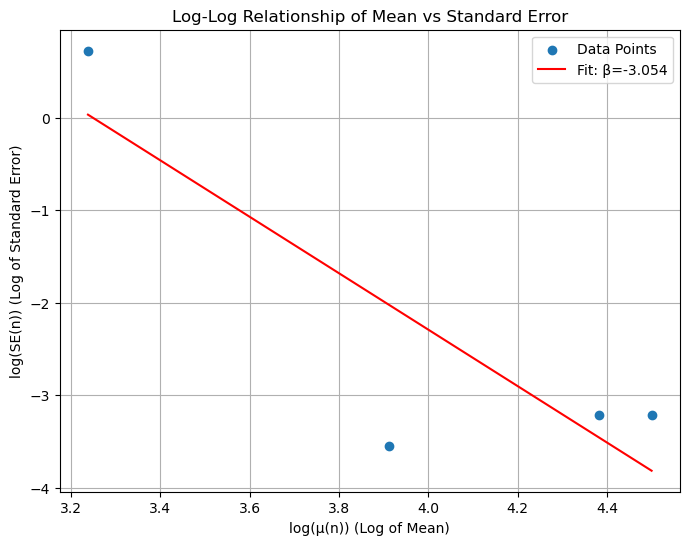

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Load the CSV file
file_path = r"C:\Users\Kaan\Desktop\thesis\csv_files\claude_cat0_r100_gen_data.csv"
data = pd.read_csv(file_path)

# The sample size (n) is the number of trials (rows in the dataset)
n_values = data.shape[0]  # Number of trials

# Compute mean and standard error for each column (excluding non-numeric columns)
numeric_columns = data.select_dtypes(include=[np.number]).columns  # Get only numeric columns
means = data[numeric_columns].mean()  # Mean for each column
stds = data[numeric_columns].std()  # Standard deviation for each column
SEs = stds / np.sqrt(n_values)  # Standard Error (SE)

# Remove cases where SE is zero to avoid log issues
valid_indices = SEs > 0
log_means = np.log(means[valid_indices])
log_SEs = np.log(SEs[valid_indices])

# Perform linear regression to compute slope β
slope, intercept, r_value, p_value, std_err = stats.linregress(log_means, log_SEs)

# Display results
print(f"Slope (β): {slope:.3f}")
print(f"Intercept (α): {intercept:.3f}")
print(f"R-squared: {r_value**2:.3f}")

# Create a dataframe to display results
results_df = pd.DataFrame({
    'Column': log_means.index,
    'log_mean': log_means.values,
    'log_SE': log_SEs.values
})

print("Log Mean vs Log SE Data:")
print(results_df.head())  # Display only the first few rows

# Plot log-log relationship
plt.figure(figsize=(8, 6))
plt.scatter(log_means, log_SEs, label="Data Points")
plt.plot(log_means, intercept + slope * log_means, color='red', label=f"Fit: β={slope:.3f}")
plt.xlabel("log(µ(n)) (Log of Mean)")
plt.ylabel("log(SE(n)) (Log of Standard Error)")
plt.title("Log-Log Relationship of Mean vs Standard Error")
plt.legend()
plt.grid(True)
plt.show()



In [17]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os

# Define the folder containing the CSV files
folder_path = r"C:\Users\Kaan\Desktop\thesis\csv_files"

# List all CSV files in the folder
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Initialize a list to store results
results = []

# Loop through each file and perform the analysis
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)

    try:
        # Load the CSV file
        data = pd.read_csv(file_path)

        # The sample size (n) is the number of trials (rows in the dataset)
        n_values = data.shape[0]  # Number of trials

        # Compute mean and standard error for each column (excluding non-numeric columns)
        numeric_columns = data.select_dtypes(include=[np.number]).columns  # Get only numeric columns
        means = data[numeric_columns].mean()  # Mean for each column
        stds = data[numeric_columns].std()  # Standard deviation for each column
        SEs = stds / np.sqrt(n_values)  # Standard Error (SE)

        # Remove cases where SE is zero to avoid log issues
        valid_indices = SEs > 0
        if valid_indices.sum() == 0:
            continue  # Skip this file if all SE values are zero

        log_means = np.log(means[valid_indices])
        log_SEs = np.log(SEs[valid_indices])

        # Perform linear regression to compute slope β and p-value
        slope, intercept, r_value, p_value, std_err = stats.linregress(log_means, log_SEs)

        # Keep only files where both conditions hold: p < 0.05 AND 0.5 ≤ β ≤ 1.5
        if p_value < 0.05 and 0.5 <= slope <= 1.5:
            results.append({"File Name": file_name, "Slope (β)": slope, "p-value": p_value})

    except Exception as e:
        print(f"Error processing file {file_name}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)


# Print the results for debugging
print(results_df)

results_df.to_csv("Weber_followers.csv")


c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: 

                             File Name  Slope (β)       p-value
0        claude_cat1_r100_gen_data.csv   1.451535  1.317011e-02
1     claude_cat1_r100_naming_data.csv   1.185338  2.116476e-02
2        claude_cat2_r100_gen_data.csv   0.894149  9.252878e-03
3     claude_cat3_r100_naming_data.csv   1.179027  4.531850e-02
4     gemini_cat3_r100_naming_data.csv   1.171826  1.274616e-02
5      gpt4o_cat3_r100_naming_data.csv   1.426115  2.427219e-03
6      llama70b_cat0_r100_gen_data.csv   1.277291  4.951077e-02
7      llama70b_cat1_r100_gen_data.csv   1.227451  7.276976e-08
8   llama70b_cat3_r100_naming_data.csv   0.844490  4.441732e-02
9       llama8b_cat0_r100_gen_data.csv   1.306948  6.290872e-08
10      llama8b_cat1_r100_gen_data.csv   1.391211  5.944269e-04
11   llama8b_cat1_r100_naming_data.csv   1.375582  3.694640e-05
12      llama8b_cat3_r100_gen_data.csv   1.481331  4.145421e-04
13   llama8b_cat3_r100_naming_data.csv   0.998052  6.692101e-03
14    llama8b_cat3_r10_naming_data.csv  

c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:182: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:196: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\Users\Kaan\anaconda3\lib\site-packages\scipy\stats\_stats_mstats_common.py:199: 

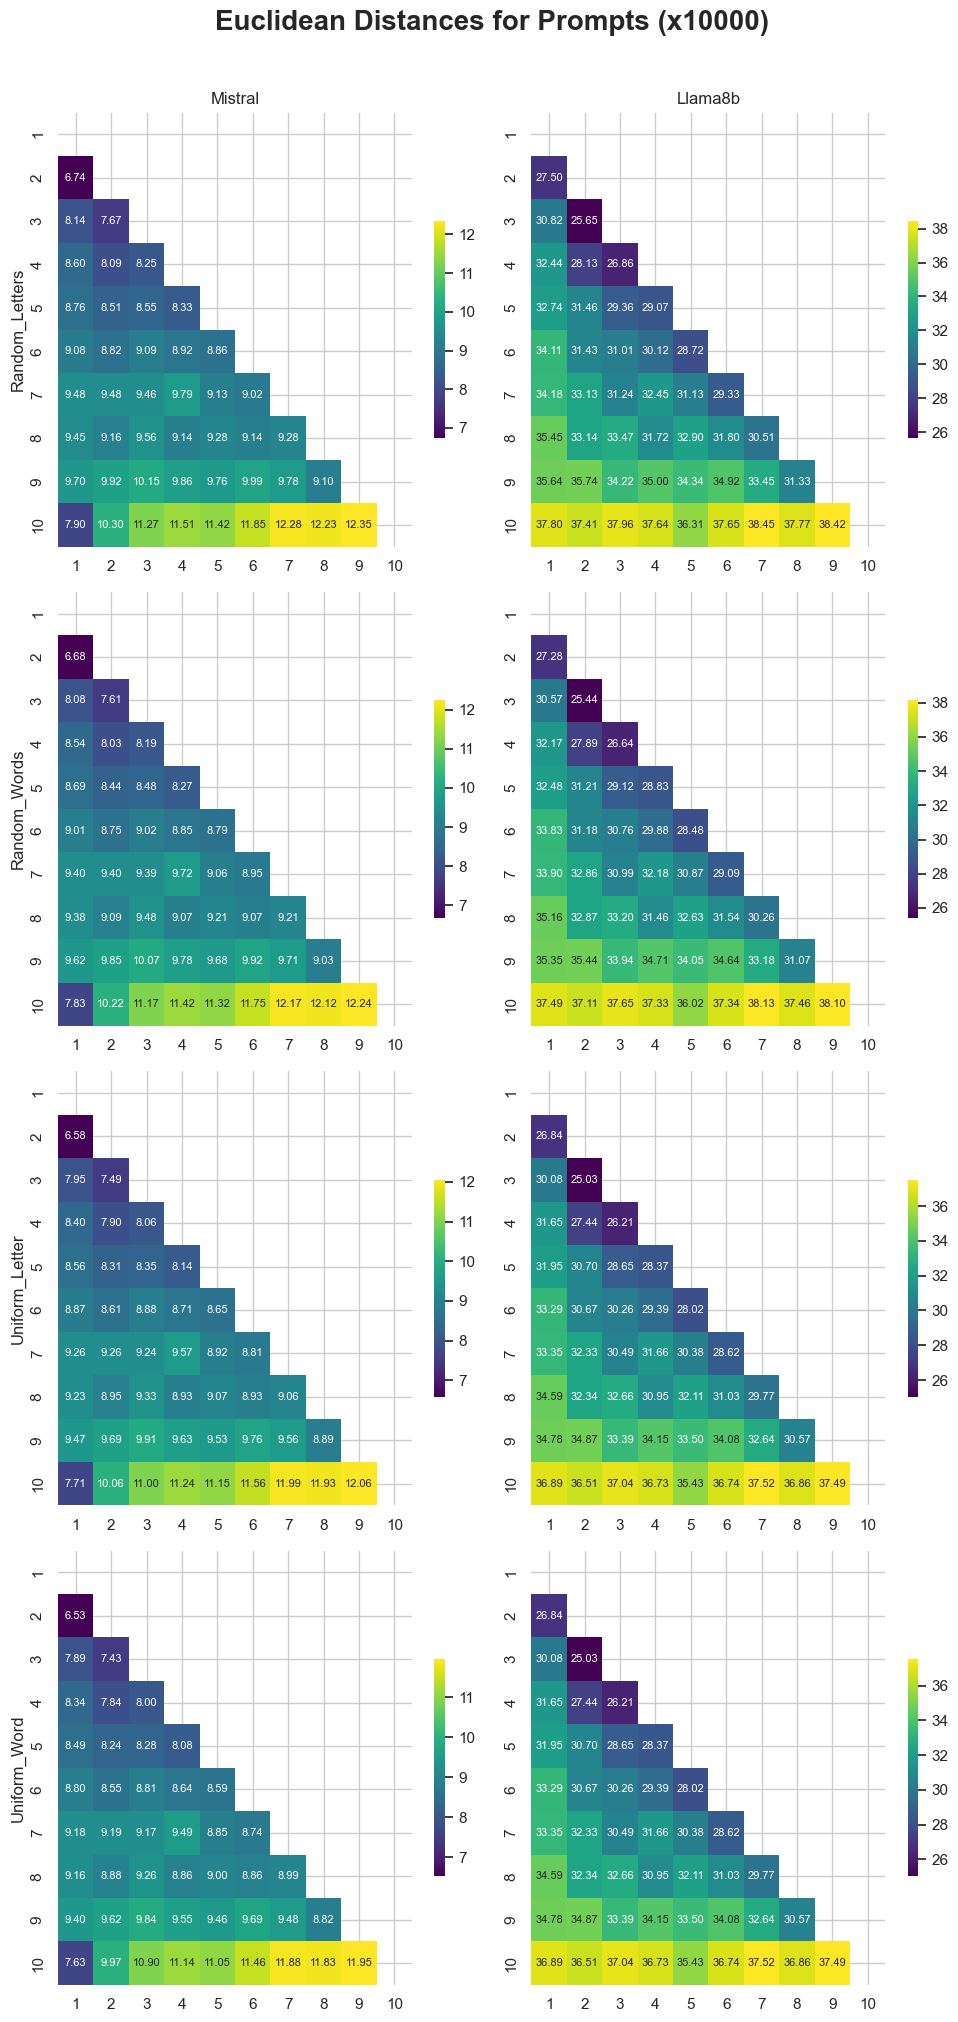

Plot saved to combined_distance_plot.png


In [57]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define folder containing files
input_folder = r"C:\Users\Kaan\Desktop\thesis\embeddings"  # Replace with the path to your folder containing the files


# List all files in the folder
files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

# Helper function to calculate Euclidean distances
def calculate_distance_matrix(data):
    num_rows = len(data)
    distance_matrix = np.zeros((num_rows, num_rows))
    for i in range(num_rows):
        for j in range(i):  # Only calculate lower triangle
            distance = np.sqrt(np.sum((data.iloc[i] - data.iloc[j]) ** 2)) * 10000
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
    return distance_matrix

# Parse file names to extract model and task
parsed_files = []
for file in files:
    parts = file.split("_")
    model = parts[0]
    task = "_".join(parts[3:]).replace(".csv", "")
    parsed_files.append((file, model, task))

# Organize parsed files by model and task
parsed_files = sorted(parsed_files, key=lambda x: (x[1], x[2]))  # Sort by model and task
tasks = sorted(set(x[2] for x in parsed_files))

# Separate files by models
mistral_files = [item for item in parsed_files if item[1] == "mistral"]
llama_files = [item for item in parsed_files if item[1] == "llama8b"]

# Create subplots
num_rows = len(tasks)
num_cols = 2  # One column for each model
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 5 * num_rows))

# Ensure axes is always 2D
axes = np.atleast_2d(axes)

# Plot each file
for task_index, task in enumerate(tasks):
    for model_index, model_files in enumerate([mistral_files, llama_files]):
        # Find the file corresponding to the current task and model
        matching_files = [item for item in model_files if item[2] == task]
        if matching_files:
            file, model, _ = matching_files[0]
            file_path = os.path.join(input_folder, file)
            data = pd.read_csv(file_path, index_col=0)  # Use first row and column as headers

            # Calculate distance matrix
            distance_matrix = calculate_distance_matrix(data)

            # Create a mask for the upper triangle
            mask = np.triu(np.ones_like(distance_matrix, dtype=bool))

            # Reapply distance matrix for annotations to ensure correct values
            annotated_matrix = np.where(mask, np.nan, distance_matrix)

            # Plot heatmap
            sns.heatmap(
                distance_matrix,
                mask=mask,
                ax=axes[task_index, model_index],
                cmap="viridis",
                cbar=True,  # Separate colorbars for each plot
                cbar_kws={"shrink": 0.5},
                annot=np.round(annotated_matrix, 2),  # Show rounded values after scaling by 1000
                fmt=".2f",
                annot_kws={"size": 8},  # Smaller font size for annotations
                xticklabels=data.index,
                yticklabels=data.index,
            )

            # Set titles and labels
            if model_index == 0:
                axes[task_index, model_index].set_ylabel(task, fontsize=12)
            if task_index == 0:
                axes[task_index, model_index].set_title("Mistral" if model_index == 0 else "Llama8b", fontsize=12)

# Adjust layout and save the plot
plt.suptitle('Euclidean Distances for Prompts (x10000)', fontsize=20, fontweight="bold", y=1.01)
plt.tight_layout()
output_file = "combined_distance_plot.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"Plot saved to {output_file}")




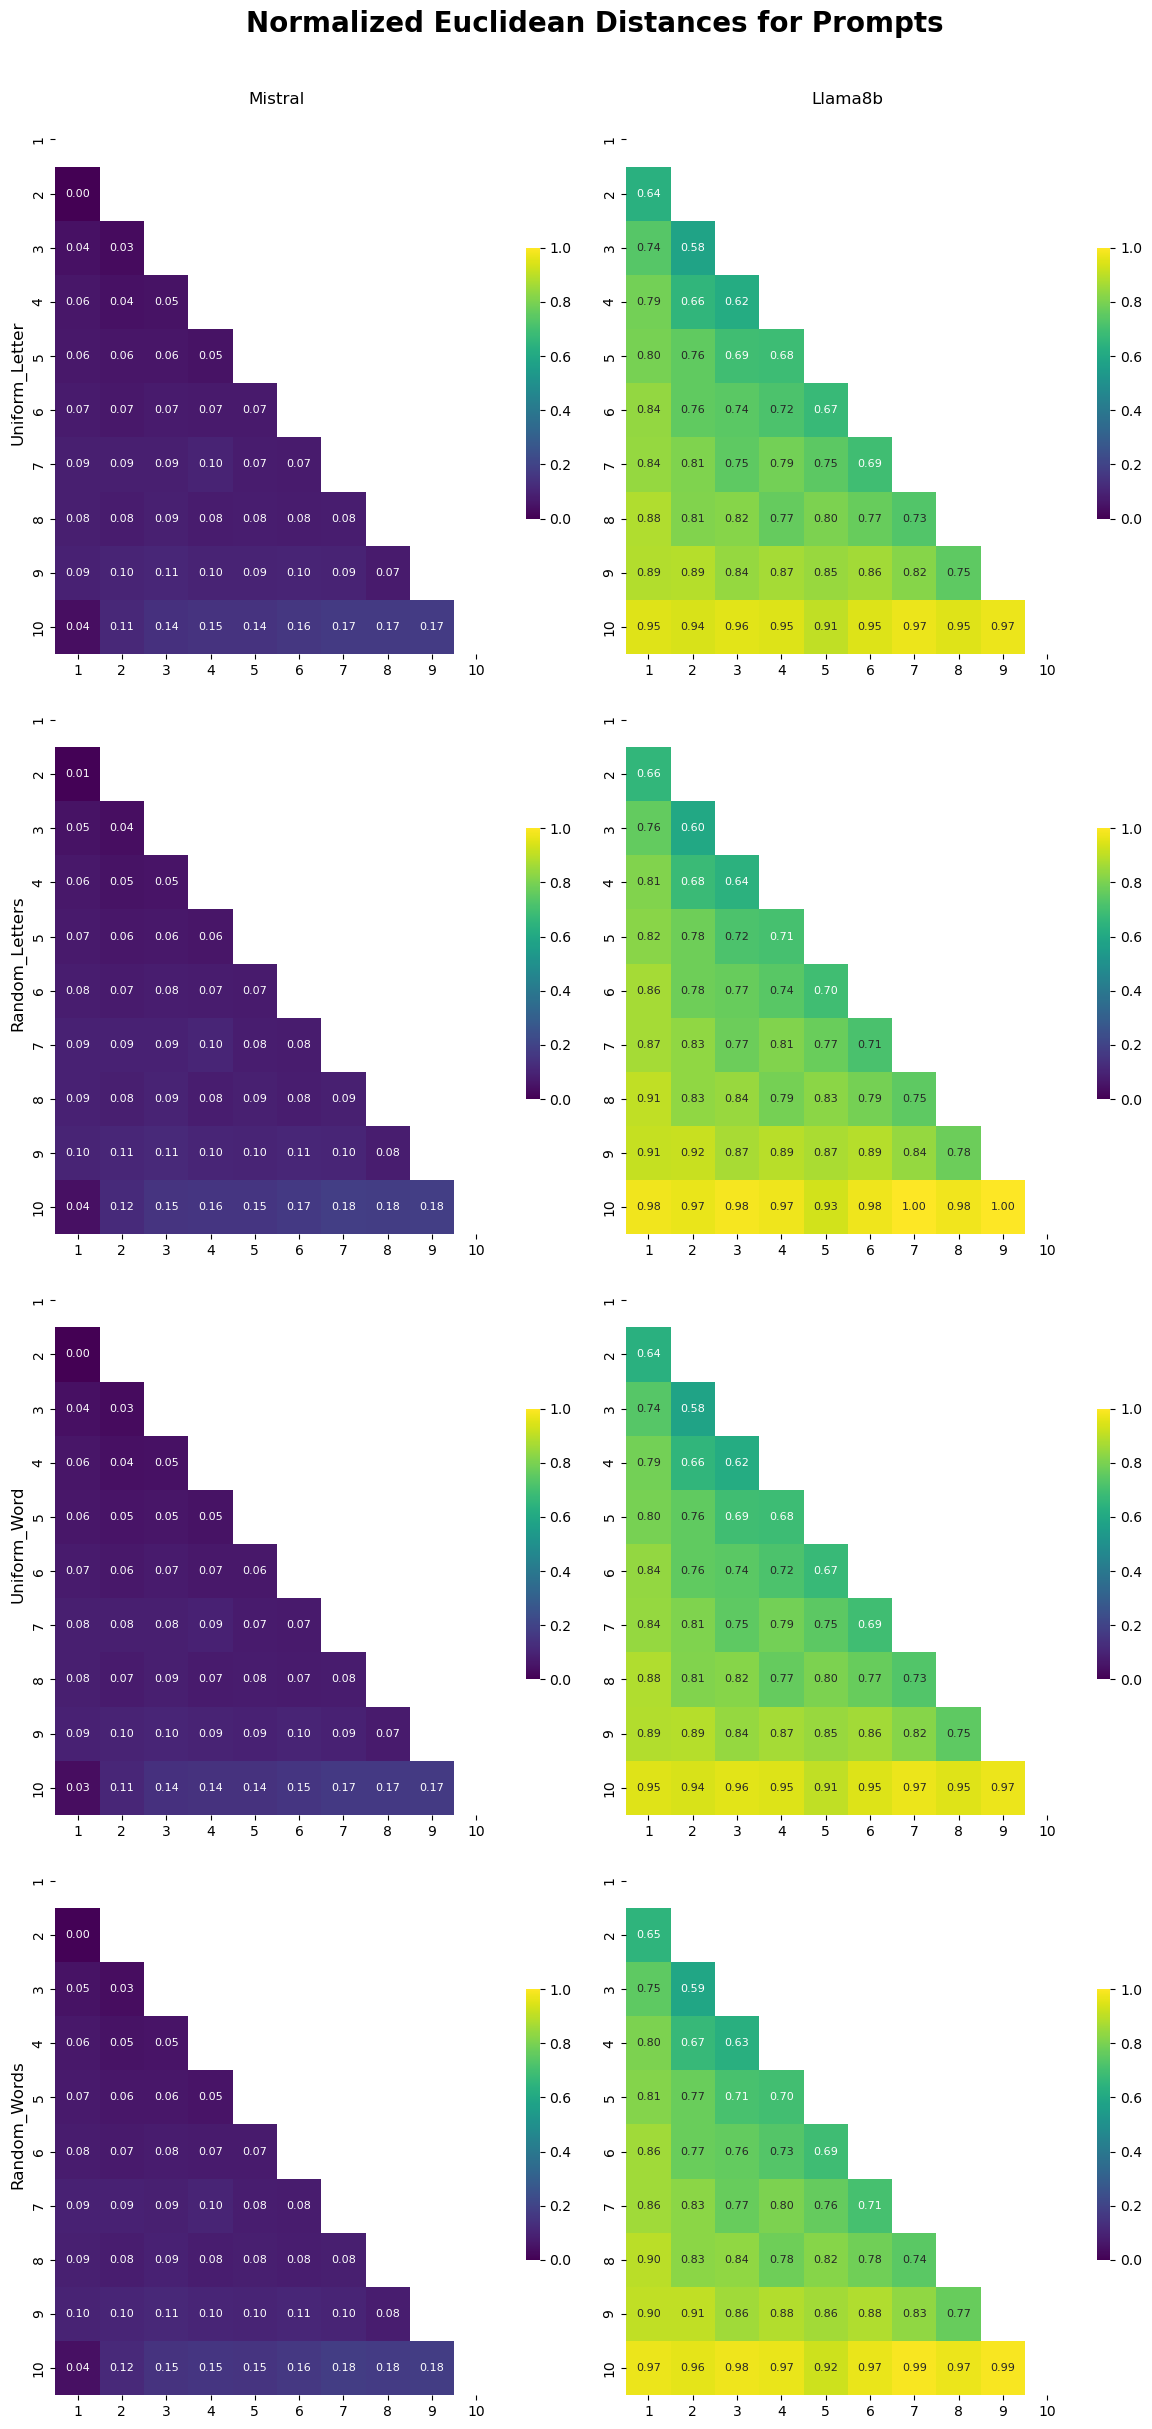

Plot saved to normalized_combined_distance_plot_no_diag.png


In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define folder containing files
input_folder = r"C:\Users\Kaan\Desktop\thesis\embeddings"  # Update path accordingly

# List all CSV files in the folder
files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

# Helper function to calculate Euclidean distances
def calculate_distance_matrix(data):
    num_rows = len(data)
    distance_matrix = np.zeros((num_rows, num_rows))
    for i in range(num_rows):
        for j in range(i):  # Only calculate lower triangle (symmetric)
            distance = np.sqrt(np.sum((data.iloc[i] - data.iloc[j]) ** 2)) * 10000
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance  # Symmetric filling
    return distance_matrix

# Parse file names to extract model and task
parsed_files = []
for file in files:
    parts = file.split("_")
    model = parts[0]
    task = "_".join(parts[3:]).replace(".csv", "")
    parsed_files.append((file, model, task))

# **Ensure correct category order**
category_order = ["Uniform_Letter", "Random_Letters", "Uniform_Word", "Random_Words"]

# Sort tasks according to predefined order
tasks = sorted(set(x[2] for x in parsed_files), key=lambda x: category_order.index(x))

# Separate files by models
mistral_files = [item for item in parsed_files if item[1] == "mistral"]
llama_files = [item for item in parsed_files if item[1] == "llama8b"]

# Calculate global min and max across all models and tasks (excluding diagonal values)
global_min, global_max = float('inf'), float('-inf')
distance_matrices = {}  # Store matrices for later plotting

for model_files in [mistral_files, llama_files]:
    for file, model, task in model_files:
        file_path = os.path.join(input_folder, file)
        data = pd.read_csv(file_path, index_col=0)
        distance_matrix = calculate_distance_matrix(data)

        # Mask out the diagonal for min-max normalization
        non_diag_values = distance_matrix[~np.eye(distance_matrix.shape[0], dtype=bool)]
        if non_diag_values.size > 0:  # Ensure non-diagonal values exist
            global_min = min(global_min, np.min(non_diag_values))
            global_max = max(global_max, np.max(non_diag_values))

        # Store the matrix
        distance_matrices[(model, task)] = distance_matrix

# Normalize all distance matrices using global min-max scaling (excluding diagonal)
for key in distance_matrices:
    distance_matrix = distance_matrices[key].copy()  # Copy original matrix
    mask = ~np.eye(distance_matrix.shape[0], dtype=bool)  # Mask for non-diagonal elements
    
    # Apply normalization only to non-diagonal elements
    distance_matrix[mask] = (distance_matrix[mask] - global_min) / (global_max - global_min)
    
    # Keep diagonal as 0 (unchanged)
    distance_matrices[key] = distance_matrix

# Create subplots
num_rows = len(tasks)
num_cols = 2  # One column per model
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6 * num_rows))

# Ensure axes is always 2D
axes = np.atleast_2d(axes)

# Plot each file in the correct order
for task_index, task in enumerate(tasks):
    for model_index, model_files in enumerate([mistral_files, llama_files]):
        # Find the file corresponding to the current task and model
        matching_files = [item for item in model_files if item[2] == task]
        if matching_files:
            file, model, _ = matching_files[0]
            distance_matrix = distance_matrices[(model, task)]

            # Create a mask for the upper triangle
            mask = np.triu(np.ones_like(distance_matrix, dtype=bool))

            # Reapply distance matrix for annotations
            annotated_matrix = np.where(mask, np.nan, distance_matrix)

            # Plot heatmap with normalized values
            sns.heatmap(
                distance_matrix,
                mask=mask,
                ax=axes[task_index, model_index],
                cmap="viridis",
                cbar=True,
                cbar_kws={"shrink": 0.5},
                annot=np.round(annotated_matrix, 2),
                fmt=".2f",
                annot_kws={"size": 8},
                xticklabels=data.index,
                yticklabels=data.index,
                vmin=0,  # Normalized range (after removing diagonal influence)
                vmax=1,  # Normalized range
            )

            # Set titles and labels
            if model_index == 0:
                axes[task_index, model_index].set_ylabel(task, fontsize=12)
            if task_index == 0:
                axes[task_index, model_index].set_title("Mistral" if model_index == 0 else "Llama8b", fontsize=12)

# Adjust layout and save the plot
plt.suptitle('Normalized Euclidean Distances for Prompts', fontsize=20, fontweight="bold", y=1.01)
plt.tight_layout()
output_file = "normalized_combined_distance_plot_no_diag.png"
plt.savefig(output_file, dpi=300)
plt.show()

print(f"Plot saved to {output_file}")


c:\Users\Kaan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kaan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


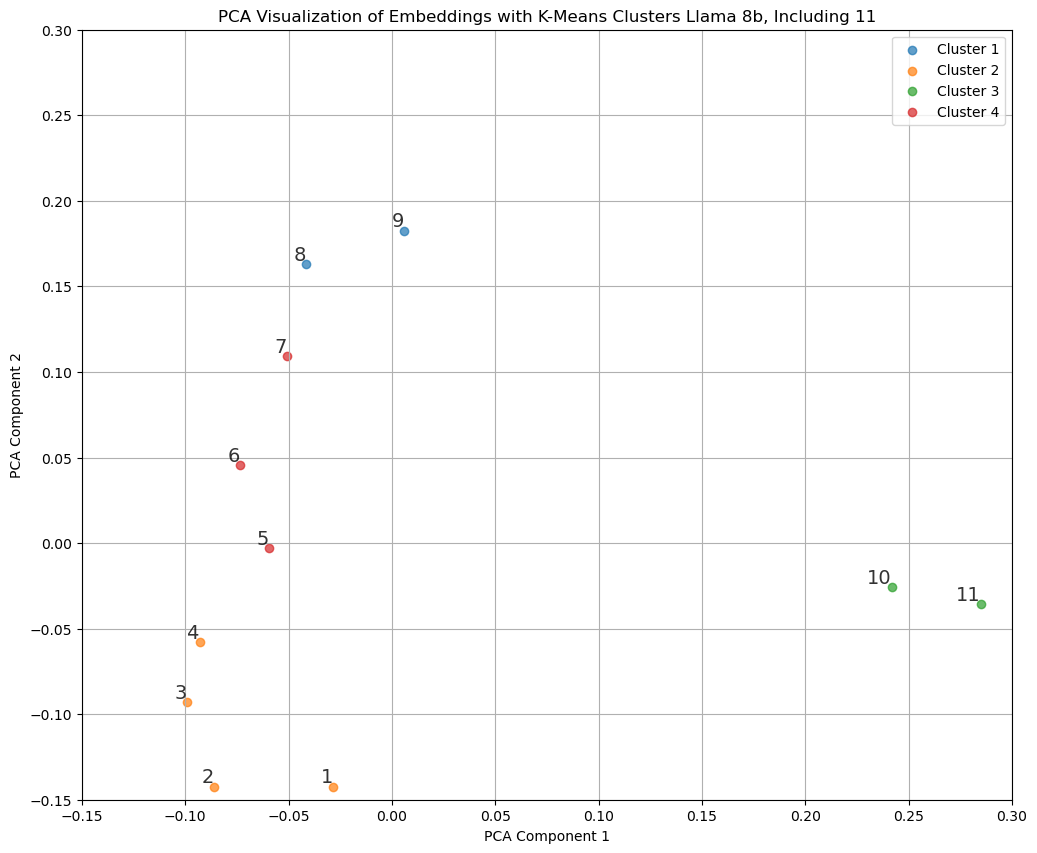

In [23]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"C:\Users\Kaan\Desktop\thesis\embedding_positions_7b.csv"  # Replace with your file path
embedding_data = pd.read_csv(file_path)

# Step 1: Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding_data)

# Step 2: Perform clustering using K-Means
num_clusters = 4  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_data)

# Step 3: Visualize the PCA results with clusters and row names
plt.figure(figsize=(12, 10))

for cluster in range(num_clusters):
    cluster_points = embedding_pca[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster + 1}", alpha=0.7)

# Add row indices as labels to the points
for i, (x, y) in enumerate(embedding_pca):
    plt.text(x, y, str(i + 1), fontsize=14, ha='right', va='bottom', alpha=0.8)

# Set axis limits
plt.xlim(-0.15, 0.3)  # Replace -10 and 10 with your desired x-axis range
plt.ylim(-0.15, 0.3)  # Replace -10 and 10 with your desired y-axis range

plt.title("PCA Visualization of Embeddings with K-Means Clusters Llama 8b, Including 11")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.grid(True)
plt.show()


c:\Users\Kaan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\Kaan\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


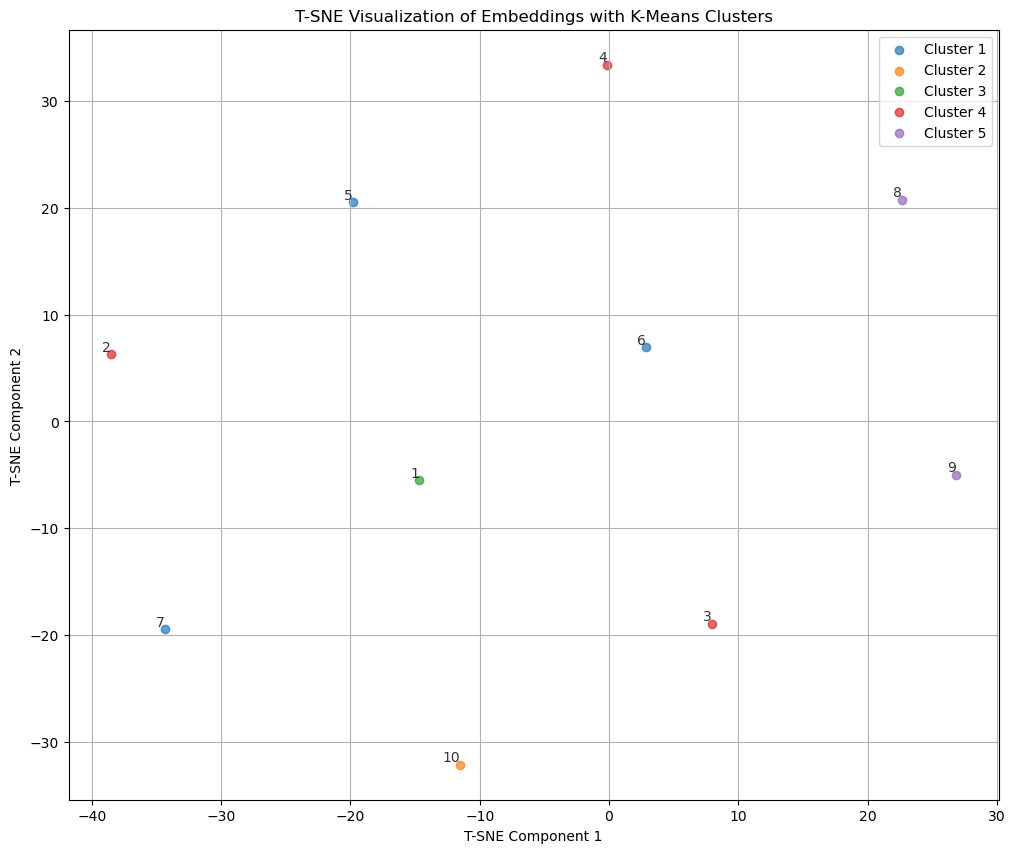

In [3]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the dataset
file_path = r"C:\Users\Kaan\Downloads\embedding_positions_1.csv"  # Replace with your file path
embedding_data = pd.read_csv(file_path)

# Check the number of samples
num_samples = embedding_data.shape[0]

# Adjust perplexity based on the number of samples
perplexity = min(30, num_samples - 1)  # Perplexity must be less than the number of samples

# Step 1: Apply T-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=1000)
embedding_tsne = tsne.fit_transform(embedding_data)

# Step 2: Perform clustering using K-Means
num_clusters = 5  # Adjust the number of clusters as needed
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_data)

# Step 3: Visualize the T-SNE results with clusters and row names
plt.figure(figsize=(12, 10))

for cluster in range(num_clusters):
    cluster_points = embedding_tsne[cluster_labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster + 1}", alpha=0.7)

# Add row indices as labels to the points
for i, (x, y) in enumerate(embedding_tsne):
    plt.text(x, y, str(i + 1), fontsize=10, ha='right', va='bottom', alpha=0.8)

plt.title("T-SNE Visualization of Embeddings with K-Means Clusters")
plt.xlabel("T-SNE Component 1")
plt.ylabel("T-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()
